#Transfer-Learning: VGG16

#1. Preparación de los datos

In [ ]:
## CARGA DE DATOS
## =============================================================================

!unrar x 'drive/MyDrive/TFM/Datasets/dataset_undersampling.rar'

In [ ]:
## ACELERACIÓN POR GPU
## =============================================================================

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 392296661494431380, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16052164128693531236
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
## Uso de Tensorflow 2.
## =============================================================================

%tensorflow_version 2.x

In [ ]:
## IMPORTACIÓN DE LAS LIBRERIAS NECESARIAS
## =============================================================================

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models    import Sequential, load_model
from tensorflow.keras.layers    import Add, Dense, Activation, GlobalAveragePooling2D, Dropout 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # imprimimos en pantalla el resultado de todos los statements

In [ ]:
## DIRECTORIOS
## =============================================================================

base_dir =  'drive/MyDrive/TFM/Transfer-Learning/VGG16/'
train_dir = 'dataset_undersampling/train'
test_dir  = 'dataset_undersampling/test'

In [ ]:
## GENERADOR DE IMÁGENES (Ayuda a cargar y transformar las imágenes por lotes )
## =============================================================================

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,                 
        target_size = (224, 224), 
        batch_size  = 32,
        shuffle=False,
        color_mode='rgb',
        class_mode  ='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (224, 224),
        batch_size  = 32,
        shuffle=False,
        color_mode='rgb',
        class_mode  ='categorical')

Found 13178 images belonging to 4 classes.
Found 3296 images belonging to 4 classes.


#2. VGG16 (Modelo Base)

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

base_model = VGG16(weights="imagenet",
                  include_top=False)

base_model.trainable = False                        

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
Total params: 14,716,740
Trainable params: 2,052
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir + 'VGG16_model.h5')

 
def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(train_generator, 
                  epochs=60,
                  validation_data=test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'VGG16_history.npy', history.history)

Epoch 1/60
412/412 [==============================] - 171s 325ms/step - loss: 1.0068 - accuracy: 0.5920 - val_loss: 0.8602 - val_accuracy: 0.6462
Epoch 2/60
412/412 [==============================] - 125s 303ms/step - loss: 0.7871 - accuracy: 0.6952 - val_loss: 0.7485 - val_accuracy: 0.7121
Epoch 3/60
412/412 [==============================] - 125s 303ms/step - loss: 0.7044 - accuracy: 0.7399 - val_loss: 0.6887 - val_accuracy: 0.7470
Epoch 4/60
412/412 [==============================] - 124s 302ms/step - loss: 0.6544 - accuracy: 0.7629 - val_loss: 0.6522 - val_accuracy: 0.7597
Epoch 5/60
412/412 [==============================] - 124s 302ms/step - loss: 0.6196 - accuracy: 0.7750 - val_loss: 0.6221 - val_accuracy: 0.7697
Epoch 6/60
412/412 [==============================] - 125s 302ms/step - loss: 0.5943 - accuracy: 0.7862 - val_loss: 0.6001 - val_accuracy: 0.7767
Epoch 7/60
412/412 [==============================] - 125s 303ms/step - loss: 0.5735 - accuracy: 0.7919 - val_loss: 0.5873 -

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'VGG16_model.h5')
history = np.load(base_dir + 'VGG16_history.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

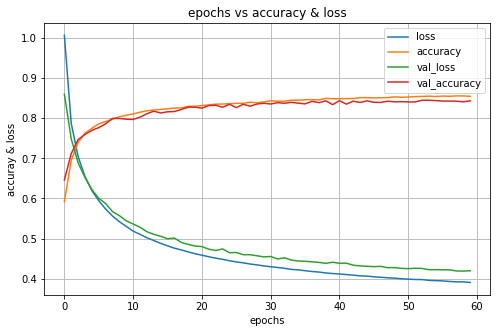

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 25s 243ms/step - loss: 0.4196 - accuracy: 0.8434


In [ ]:
## PREDICCIÓN DEL DATASET DE PRUEBA
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 1, 0, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORÍAS
## =============================================================================

class_names = val_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

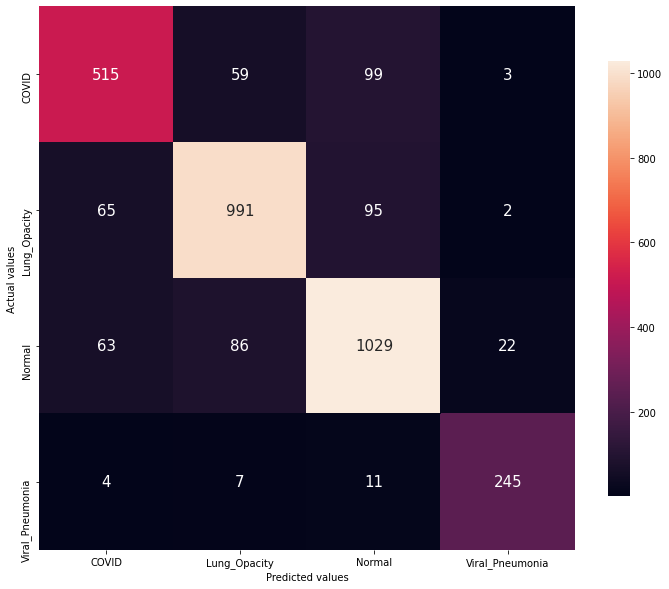

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## =============================================================================

import seaborn as sns

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## METRICAS
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.80      0.76      0.78       676
   Lung_Opacity       0.87      0.86      0.86      1153
         Normal       0.83      0.86      0.85      1200
Viral_Pneumonia       0.90      0.92      0.91       267

       accuracy                           0.84      3296
      macro avg       0.85      0.85      0.85      3296
   weighted avg       0.84      0.84      0.84      3296



#3. VGG16 (Modelo Base + 2 capas densas)

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

base_model = VGG16(weights="imagenet",
                  include_top=False)

base_model.trainable = False                        

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir + 'VGG16_Dense_model.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(train_generator, 
                  epochs=60,
                  validation_data=test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'VGG16_Dense_history.npy', history.history)

Epoch 1/60
412/412 [==============================] - 126s 304ms/step - loss: 0.9667 - accuracy: 0.5951 - val_loss: 0.7850 - val_accuracy: 0.6426
Epoch 2/60
412/412 [==============================] - 125s 303ms/step - loss: 0.7704 - accuracy: 0.6885 - val_loss: 0.6184 - val_accuracy: 0.7558
Epoch 3/60
412/412 [==============================] - 125s 303ms/step - loss: 0.7165 - accuracy: 0.7146 - val_loss: 0.5770 - val_accuracy: 0.7992
Epoch 4/60
412/412 [==============================] - 125s 303ms/step - loss: 0.6836 - accuracy: 0.7264 - val_loss: 0.5819 - val_accuracy: 0.7967
Epoch 5/60
412/412 [==============================] - 125s 303ms/step - loss: 0.6740 - accuracy: 0.7270 - val_loss: 0.5536 - val_accuracy: 0.8007
Epoch 6/60
412/412 [==============================] - 125s 303ms/step - loss: 0.6571 - accuracy: 0.7374 - val_loss: 0.5726 - val_accuracy: 0.7676
Epoch 7/60
412/412 [==============================] - 125s 303ms/step - loss: 0.6481 - accuracy: 0.7395 - val_loss: 0.5288 -

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'VGG16_Dense_model.h5')
history = np.load(base_dir + 'VGG16_Dense_history.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

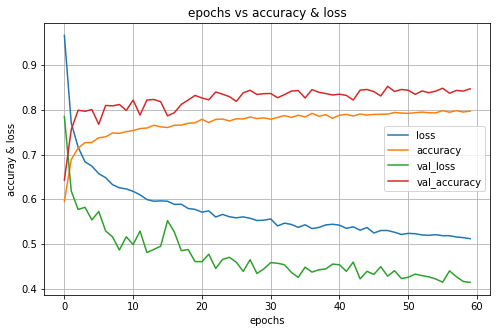

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 25s 244ms/step - loss: 0.4136 - accuracy: 0.8471


In [ ]:
## PREDICCIÓN DEL MODELO
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 1, 3, ..., 3, 2, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORÍAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

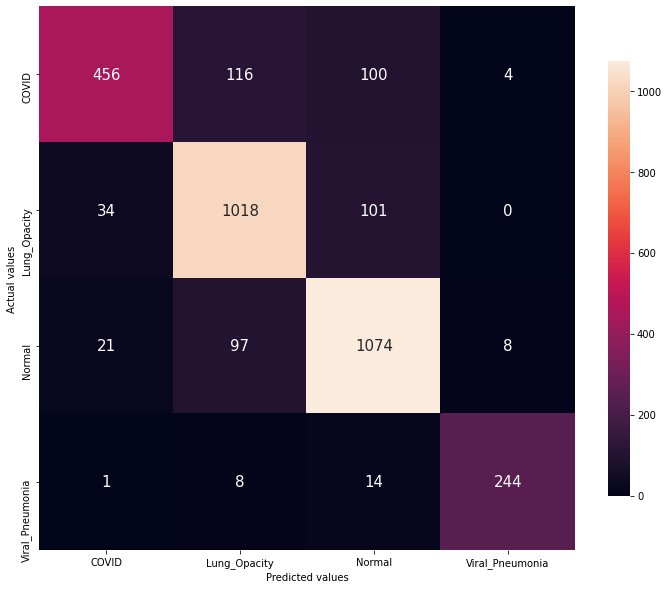

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## =============================================================================

import seaborn as sns

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## Métricas
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.89      0.67      0.77       676
   Lung_Opacity       0.82      0.88      0.85      1153
         Normal       0.83      0.90      0.86      1200
Viral_Pneumonia       0.95      0.91      0.93       267

       accuracy                           0.85      3296
      macro avg       0.87      0.84      0.85      3296
   weighted avg       0.85      0.85      0.84      3296



#4. VGG16 (Modelo Base + 2 capas densas + últimas capas entrenables)

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

base_model = VGG16(weights="imagenet",
                  include_top=False)

base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
## DESBLOQUEO DE LAS ÚLTIMAS CAPAS CONVOLUCIONALES
## =============================================================================

base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv2', 'block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False                     

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
## AÑADIDO DE DOS CAPAS DENSAS
## =============================================================================

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir + 'VGG16_Last_Layer_Trainable_model.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(train_generator, 
                  epochs=60,
                  validation_data=test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'VGG16_Last_Layer_Trainable_history.npy', history.history)

Epoch 1/60
412/412 [==============================] - 171s 325ms/step - loss: 0.6737 - accuracy: 0.7286 - val_loss: 0.3818 - val_accuracy: 0.8529
Epoch 2/60
412/412 [==============================] - 126s 306ms/step - loss: 0.3623 - accuracy: 0.8667 - val_loss: 0.2918 - val_accuracy: 0.8911
Epoch 3/60
412/412 [==============================] - 126s 306ms/step - loss: 0.2951 - accuracy: 0.8934 - val_loss: 0.2853 - val_accuracy: 0.8981
Epoch 4/60
412/412 [==============================] - 126s 306ms/step - loss: 0.2397 - accuracy: 0.9132 - val_loss: 0.3276 - val_accuracy: 0.8759
Epoch 5/60
412/412 [==============================] - 126s 306ms/step - loss: 0.2187 - accuracy: 0.9210 - val_loss: 0.4479 - val_accuracy: 0.8504
Epoch 6/60
412/412 [==============================] - 126s 306ms/step - loss: 0.2063 - accuracy: 0.9268 - val_loss: 0.2377 - val_accuracy: 0.9187
Epoch 7/60
412/412 [==============================] - 126s 305ms/step - loss: 0.1659 - accuracy: 0.9398 - val_loss: 0.3182 -

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'VGG16_Last_Layer_Trainable_model.h5')
history = np.load(base_dir + 'VGG16_Last_Layer_Trainable_history.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

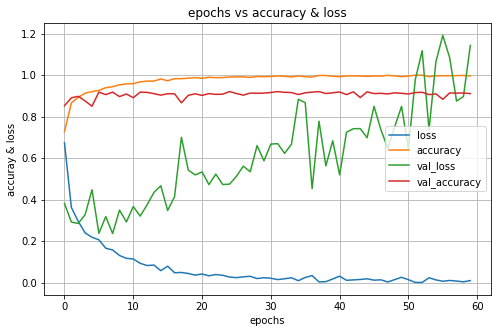

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 25s 241ms/step - loss: 1.1430 - accuracy: 0.9114


In [ ]:
## PREDICCIÓN DEL MODELO
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 1, 0, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORIAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

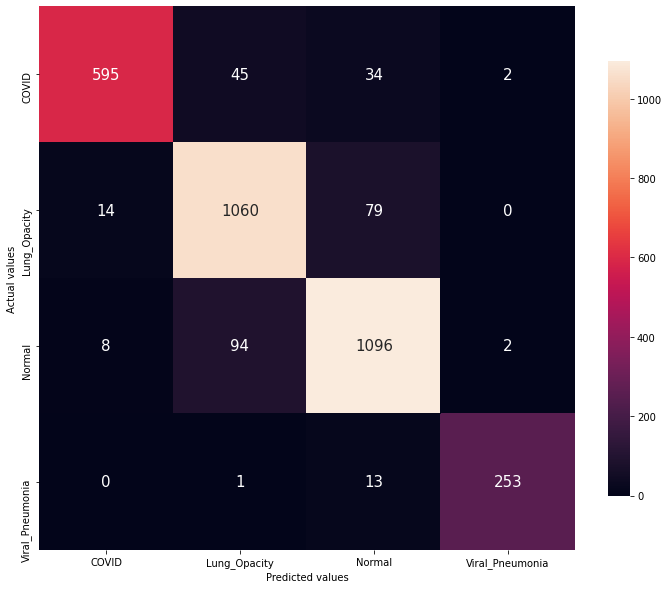

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualizacion)
## =============================================================================

import seaborn as sns

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## Métricas
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.96      0.88      0.92       676
   Lung_Opacity       0.88      0.92      0.90      1153
         Normal       0.90      0.91      0.91      1200
Viral_Pneumonia       0.98      0.95      0.97       267

       accuracy                           0.91      3296
      macro avg       0.93      0.92      0.92      3296
   weighted avg       0.91      0.91      0.91      3296

